In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os
import pickle
from scipy.io import loadmat, savemat
from scipy.stats import ttest_1samp
from scipy.signal import detrend
from tqdm import tqdm
from nilearn.connectome import ConnectivityMeasure
from itertools import combinations
from nilearn import plotting
import functions.functions as f
from mvmd.mvmd import mvmd
import importlib
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
importlib.reload(f)               # Reload the module
modules_brain, modules_brain_ranges = f.get_atlas_modules()

### Download extra data

In [2]:
def get_psilocin_df(psilocin_data= 'data/np2p3_psilocin_sdi_202504_remade.csv'):
    psilocin_data = pd.read_csv(psilocin_data)
    psilocin_data.cimbi_id = 'sub-'+psilocin_data.cimbi_id.astype(str)
    #psilocin_data['run'] = psilocin_data.mr_name.apply(lambda x : int(x.split('rest')[1]))

    psilocin_data.psi_conc_mcg_per_L.fillna(0, inplace=True)
    psilocin_data.SDI_score.fillna(0, inplace=True)

    column_types = {'cimbi_id': str, 'run':int, 'mr_name': str, 'time_since_admin': int,
                    'psi_conc_mcg_per_L': float, 'SDI_score': int}

    psilocin_data = psilocin_data.astype(column_types)

    renamed_columns = {'cimbi_id': 'subject', 'time_since_admin': 'time_since_admin', 
                    'psi_conc_mcg_per_L': 'psi', 'SDI_score': 'SDI'}
    psilocin_data.rename(columns=renamed_columns, inplace=True)
    psilocin_data['time_since_admin'] = psilocin_data['time_since_admin'].apply(lambda x : max(x, 0)) 

    psilocin_data['psi'] = psilocin_data['psi']* 1000  # Convert to ng/mL
    return psilocin_data

def append_psilocin_data(data_df, psilocin_data):
    # Merge the two DataFrames on the 'subject' and 'run' column
    psilocin_data = get_psilocin_df(psilocin_data)
    
    merged_df = pd.merge(data_df, psilocin_data, on=['subject', 'run'], how='left')
    
    # Fill NaN values with 0    
    return merged_df

def load_and_append_psilocin_data(data_df):
    psilocin_data = 'data/np2p3_psilocin_sdi_202504_remade.csv'
    new_df = data_df.copy()
    if 'subject' not in data_df.columns:
        new_df.rename(columns={'participant': 'subject'}, inplace=True)
    new_df = append_psilocin_data(new_df, psilocin_data)
    new_df.dropna(subset=['psi'], inplace=True)
    return new_df
modules_brain, modules_brain_ranges = f.get_atlas_modules()

def get_data(data_df, mode, sample_rate, column = 'u', zFisher = True):
    long_data = []
    for run in tqdm(range(0,9)):
        
        x = data_df.loc[(data_df['run'] == run) & (data_df['sample_rate'] == sample_rate)]
        
        u_data = x[column].values
        subjects = x['subject'].values
        psis = x['psi'].values
        sdi = x['SDI'].values
        corr_mat_listr1 = f.correlation_matrices(u_data, mode=mode, participant_list=range(len(u_data)), zFisher=zFisher, modules=modules_brain)
        for i, mat in enumerate(corr_mat_listr1):
            subject_id = subjects[i]
            
            ac = f.average_connectivity(mat, modules_brain_ranges)
            long_data.append({
                'subject': subject_id,
                'run': run,
                'psi': psis[i],
                'SDI': sdi[i],
                'average_connecvtivities': ac,
                'mat': mat   
            })        
    return pd.DataFrame(long_data)

def get_data_modified(data_df, modes, sample_rate, column = 'u', zFisher = True):
    long_data = []
    for run in tqdm(range(0,9)):
        
        x = data_df.loc[(data_df['run'] == run) & (data_df['sample_rate'] == sample_rate)]
        
        u_data = [np.sum(participant[modes, :, :], axis=0) for participant in x['u'].values]
        
        subjects = x['subject'].values
        psis = x['psi'].values
        sdi = x['SDI'].values
        corr_mat_listr1 = correlation_matrices_modified(u_data, range(len(u_data)), zFisher=zFisher, modules=modules_brain)
        for i, mat in enumerate(corr_mat_listr1):
            subject_id = subjects[i]
            
            ac= f.average_connectivity(mat, modules_brain_ranges)
            long_data.append({
                'subject': subject_id,
                'run': run,
                'psi': psis[i],
                'SDI': sdi[i],
                'average_connecvtivities': ac,
                'mat' : mat
                
            })        
    return pd.DataFrame(long_data)

def correlation_matrices_modified(u_data, participant_list, modules = None, zFisher=True, threshold=0, N=232):
    """Modified function to calculate correlation matrices for each participant, but the u_data is already calculated.
    """
    
    def reorder_by_modules(data, modules_brain):
        # Reorder mode x region x time by modules
        new_order = []
        for module, indices in modules_brain.items():
            new_order.extend(indices)

        reordered_data = data[new_order, :]
        return reordered_data
    
    corr_matrix_list = []
    
    for participant in participant_list:
        # Take individual data
        
        u_ind = u_data[participant]
        if modules != None:
            u_ind = reorder_by_modules(u_ind, modules)
        
        df = pd.DataFrame(u_ind.T)
        corr_mat = np.array(df.corr().fillna(0.0))
        corr_mat = corr_mat[:N, :N]
        
        
            
        # Remove diagonal
        for i in range(len(corr_mat)):
            corr_mat[i][i] = 0
        
        # zFisher transform?
        if zFisher:
            corr_mat = np.arctanh(corr_mat)
            
        # Threshold ?
        if threshold != 0:
            corr_mat[np.abs(corr_mat) < threshold] = 0
            
        corr_matrix_list.append(corr_mat)
        
    return corr_matrix_list



def calculate_average_connectivity_diff_regions(row):
    # Filter the dictionary to include only keys where region1 != region2
    filtered_values = [value for (region1, region2), value in row.items() if region1 != region2]
    # Calculate the average of the filtered values
    return sum(filtered_values) / len(filtered_values) if filtered_values else 0


def calculate_average_connectivity_same_regions(row):
    # Filter the dictionary to include only keys where region1 != region2
    filtered_values = [value for (region1, region2), value in row.items() if region1 == region2]
    # Calculate the average of the filtered values
    return sum(filtered_values) / len(filtered_values) if filtered_values else 0

def lme_1(df_sub, predictor, corrected = True):
    # RETURNS R and beta
    columns = ['default_conn', 'average_connectivity_within_regions', 'average_connectivity_diff_regions']
    p_unc = []
    Rs = []
    for column in columns:
        m = smf.mixedlm(f"{column} ~ {predictor}", df_sub,
                        groups=df_sub["subject"])
        
        m = m.fit(reml=True)
        p_unc.append(m.pvalues[predictor])
        t  = m.tvalues[predictor]
        df = m.df_resid
        R  = t / (t**2 + df)**0.5
        Rs.append(R)
    
    
    reject, p_fwer, _, _ = multipletests(p_unc, alpha=0.05, method="holm")
    
    if corrected:
        return p_fwer, Rs
    else:
        return p_unc, Rs

def lme_2(df_sub, predictor, column):
    # RETURNS R and beta
    m = smf.mixedlm(f"{column} ~ {predictor}", df_sub,
                    groups=df_sub["subject"])
    
    m = m.fit(reml=True)
    p_unc = m.pvalues[predictor]
    
    reject, p_fwer, _, _ = multipletests(p_unc, alpha=0.05, method="holm")
    t  = m.tvalues[predictor]
    df = m.df_resid
    R  = t / (t**2 + df)**0.5
    return p_fwer[0], R

In [4]:
from scipy.signal import butter, filtfilt

def band_pass_filter(signal, lowcut, highcut, fs, order=4):
    """
    Apply a band-pass filter to a signal.

    Parameters:
        signal (array-like): The input signal.
        lowcut (float): The lower cutoff frequency (Hz).
        highcut (float): The upper cutoff frequency (Hz).
        fs (float): The sampling frequency (Hz).
        order (int): The order of the filter.

    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


## Plots for concentration and psilocin levels

In [5]:
psilocin_data = get_psilocin_df()
psilocin_data[psilocin_data['subject'] == 'sub-55992']

,subject,run,sample_name,mr_name,mr_scan_date,clock_time,drug_admin_time,time_since_admin,psi,SDI
91,sub-55992,0,PDRU,p381rest0,12/05/2019,10:12,10:40,0,0.000000,0
92,sub-55992,3,T140,p381rest3,12/05/2019,13:44,10:40,184,8.083608,5
93,sub-55992,4,T300,p382rest0,12/05/2019,16:23,10:40,343,2.578763,1


In [21]:
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)

subject_with_max_psi = 'sub-55992'

#data_df = data_df[data_df['subject'] == subject_with_max_psi]

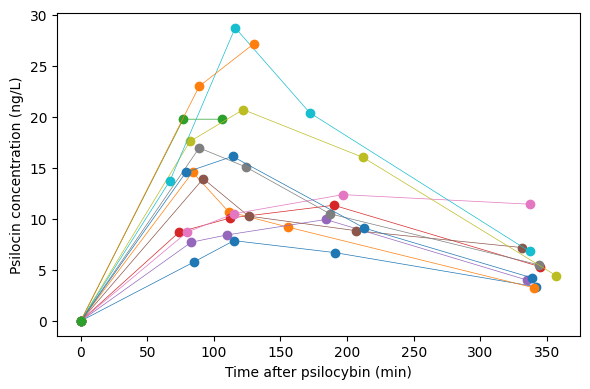

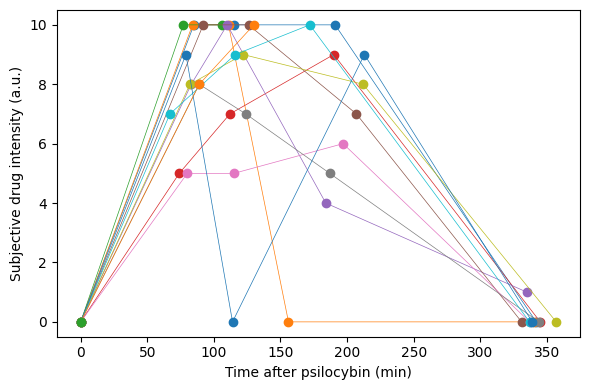

In [22]:
# Ensure proper sorting
data_df = data_df.sort_values(["subject", "time_since_admin"])
data_df = data_df[data_df['sample_rate'] == 0.8]
subjects = data_df["subject"].unique()



#psilocybin vs time
plt.figure(figsize=(6,4))

for subj in subjects:
    sub = data_df[data_df["subject"] == subj]
    plt.plot(sub["time_since_admin"], sub["psi"], marker="o", linewidth=0.5)

# population-mean (thick grey-ish line; letting matplotlib choose colour)
#mean_psi = df.groupby("time_min")["psi_conc"].mean().reset_index()
#plt.plot(mean_psi["time_min"], mean_psi["psi_conc"], linewidth=4)

plt.xlabel("Time after psilocybin (min)")
plt.ylabel("Psilocin concentration (ng/L)")
plt.tight_layout()
plt.show()

#sdi

plt.figure(figsize=(6,4))

for subj in subjects:
    sub = data_df[data_df["subject"] == subj]
    plt.plot(sub["time_since_admin"], sub["SDI"], marker="o", linewidth=0.5)

#mean_int = df.groupby("time_min")["intensity"].mean().reset_index()
#plt.plot(mean_int["time_min"], mean_int["intensity"], linewidth=4)

plt.xlabel("Time after psilocybin (min)")
plt.ylabel("Subjective drug intensity (a.u.)")
#plt.title("b  Subjective intensity over time")
plt.tight_layout()
plt.show()

## Psilocin concentration

### MVMD Detrended data

100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


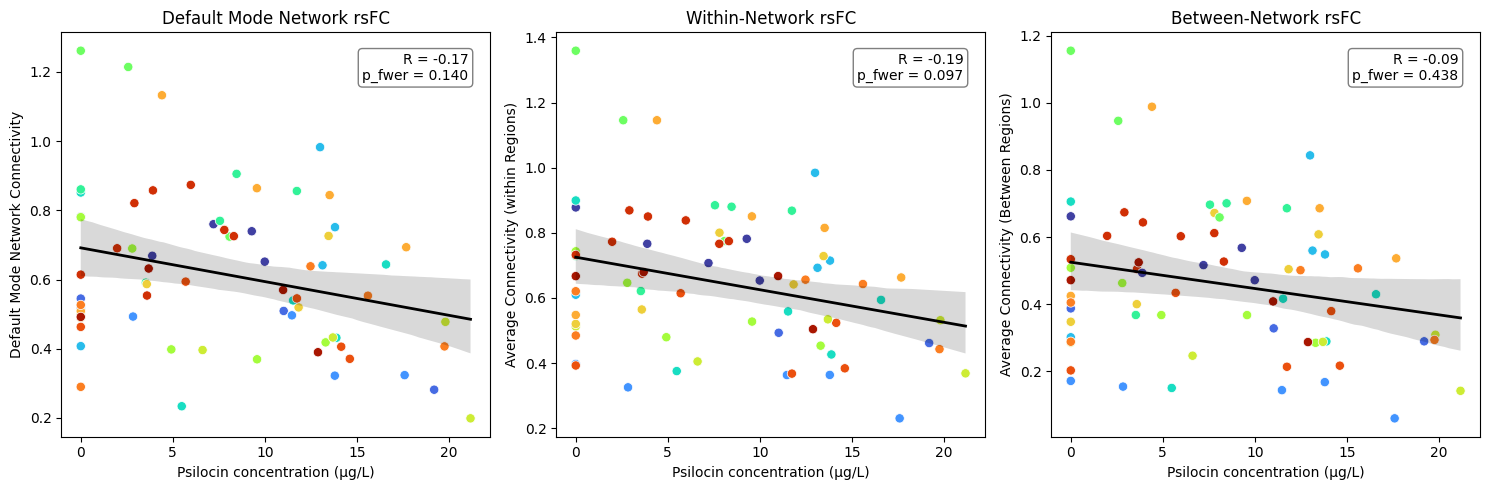

In [17]:
data_df_modes = f.experiment_to_df('Run0605/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
#data_df_modes = data_df_modes[data_df_modes['subject'] == 'sub-53888']
results_df = get_data_modified(data_df_modes, modes = [1], sample_rate=2, zFisher=True)
#results_df = get_data(data_df, mode = 1, sample_rate=2)

results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax1, ax2, ax3 = axes   
# Left subplot: default_conn
p, R = lme_1(results_df, 'psi')
sns.scatterplot(ax=ax1, x='psi', y='default_conn', hue='subject', data=results_df, s=45, palette='turbo', legend=False)
sns.regplot(ax=ax1, x='psi', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax1.set_ylabel('Default Mode Network Connectivity')
ax1.set_title(f'Default Mode Network rsFC')

textstr = f"R = {R[0]:.2f}\np_fwer = {p[0]:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='psi', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax2, x='psi', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')

textstr = f"R = {R[1]:.2f}\np_fwer = {p[1]:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax3.set_ylabel('Average Connectivity (Between Regions)')
ax3.set_title(f'Between-Network rsFC')

textstr = f"R = {R[2]:.2f}\np_fwer = {p[2]:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Bandpassed preproc data

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/mod

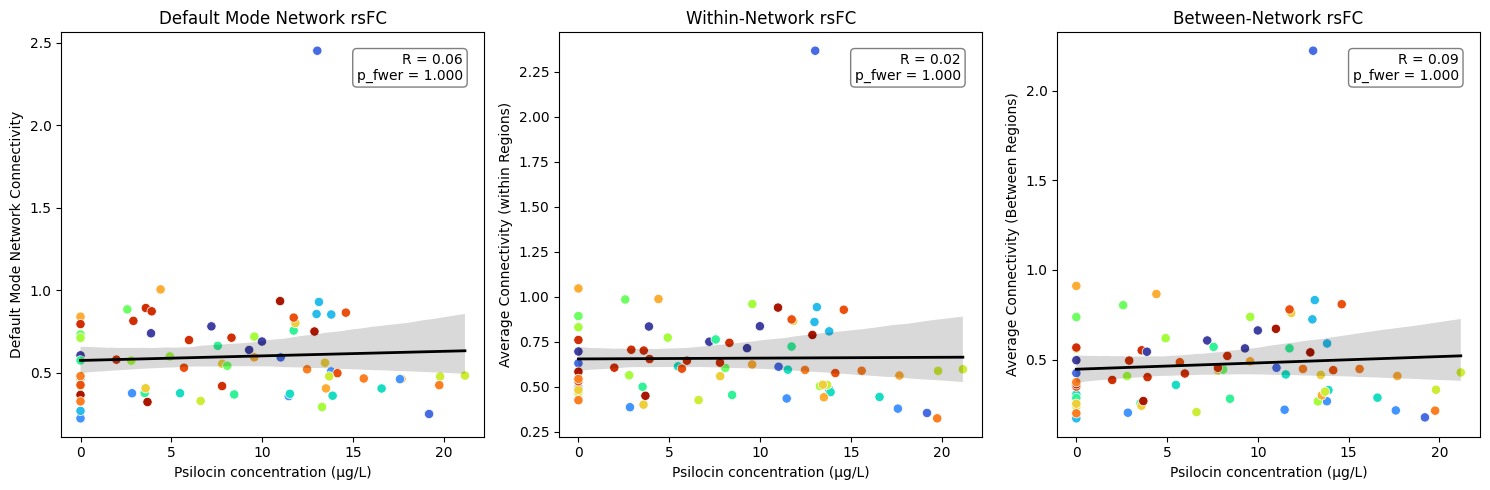

In [8]:
data_df = pickle.load(open('DATA/preproc.pkl', 'rb'))
sr = 2
data_df = data_df[data_df['sample_rate'] == sr]
data_df.u = data_df.u.apply(lambda x: band_pass_filter(x, 0.008, 0.09, fs = sr))
data_df = load_and_append_psilocin_data(data_df)

results_df = get_data(data_df, mode = 0, sample_rate=sr)
results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax1, ax2, ax3 = axes   
# Left subplot: default_conn
p, R = lme_1(results_df, 'psi')
sns.scatterplot(ax=ax1, x='psi', y='default_conn', hue='subject', data=results_df, s=45, palette='turbo', legend=False)
sns.regplot(ax=ax1, x='psi', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax1.set_ylabel('Default Mode Network Connectivity')
ax1.set_title(f'Default Mode Network rsFC')

textstr = f"R = {R[0]:.2f}\np_fwer = {p[0]:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='psi', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax2, x='psi', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')

textstr = f"R = {R[1]:.2f}\np_fwer = {p[1]:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax3.set_ylabel('Average Connectivity (Between Regions)')
ax3.set_title(f'Between-Network rsFC')

textstr = f"R = {R[2]:.2f}\np_fwer = {p[2]:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Denoised Data

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


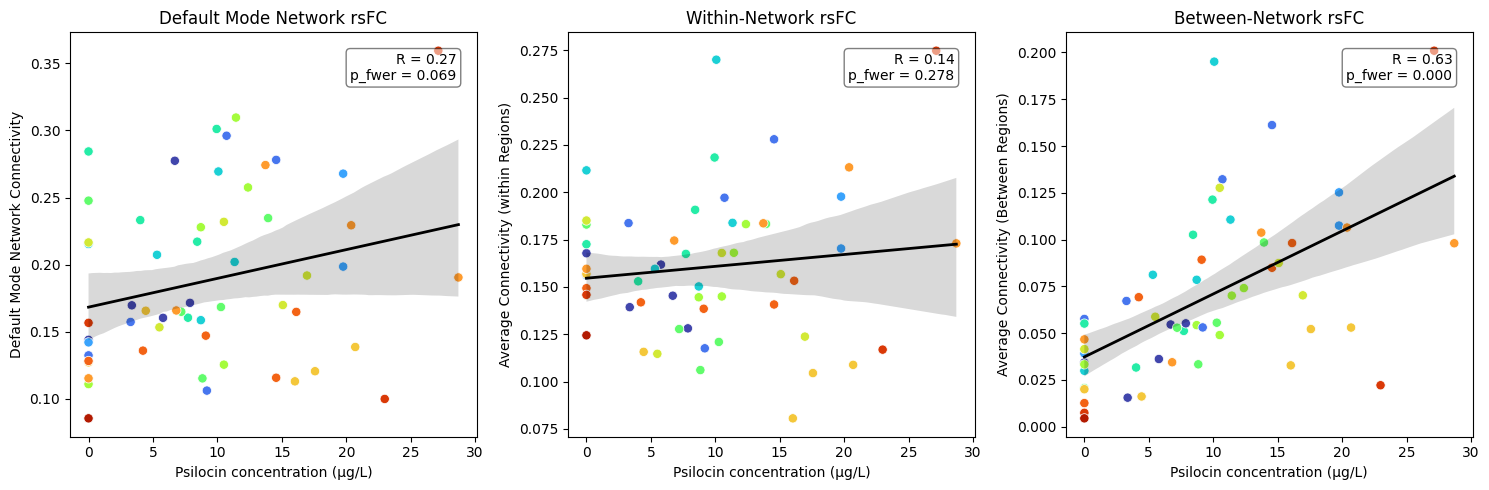

In [10]:
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
#data_df = data_df[data_df['subject'] == subject_with_max_psi]

results_df = get_data(data_df, mode = 0, sample_rate=0.8)

results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])
#results_df = results_df[results_df['subject'] == 'sub-56114']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes   
p, R = lme_1(results_df, 'psi')
sns.scatterplot(ax=ax1, x='psi', y='default_conn', hue='subject', data=results_df, s=45, palette='turbo', legend=False)
sns.regplot(ax=ax1, x='psi', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax1.set_ylabel('Default Mode Network Connectivity')
ax1.set_title(f'Default Mode Network rsFC')

textstr = f"R = {R[0]:.2f}\np_fwer = {p[0]:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='psi', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax2, x='psi', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')

textstr = f"R = {R[1]:.2f}\np_fwer = {p[1]:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax3.set_ylabel('Average Connectivity (Between Regions)')
ax3.set_title(f'Between-Network rsFC')

textstr = f"R = {R[2]:.2f}\np_fwer = {p[2]:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### MVMD on denoised

100%|██████████| 9/9 [00:02<00:00,  3.50it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


NameError: name 'R' is not defined

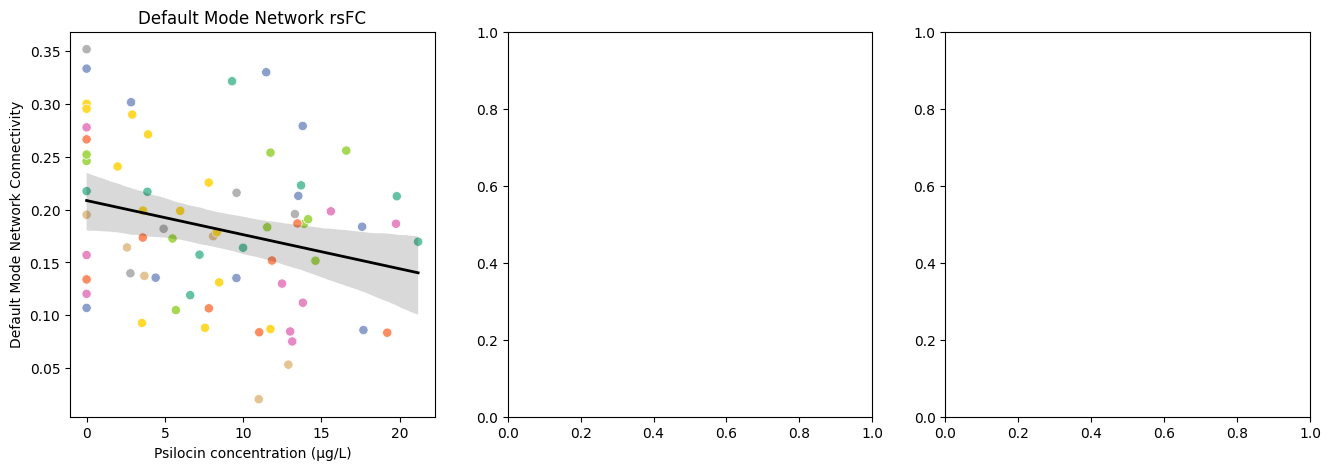

In [ ]:
data_df_modes = f.experiment_to_df('Run0605/Results_denoised', sub2000 = 'K_6', sub800='K_10')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
#data_df_modes = data_df_modes[data_df_modes['subject'] == 'sub-53888']
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # Create a grid of subplots for 6 modes
# Generate results for the current mode
results_df = get_data_modified(data_df_modes, modes = [0,1], sample_rate=2, zFisher=True)
#results_df = get_data(data_df, mode = 1, sample_rate=2)
results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])

ax1, ax2, ax3 = axes   
# Left subplot: default_conn
p, R = lme_1(results_df, 'psi')
sns.scatterplot(ax=ax1, x='psi', y='default_conn', hue='subject', data=results_df, s=45, palette='turbo', legend=False)
sns.regplot(ax=ax1, x='psi', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax1.set_ylabel('Default Mode Network Connectivity')
ax1.set_title(f'Default Mode Network rsFC')

textstr = f"R = {R[0]:.2f}\np_fwer = {p[0]:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='psi', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax2, x='psi', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')

textstr = f"R = {R[1]:.2f}\np_fwer = {p[1]:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=45, legend=False)
sns.regplot(ax=ax3, x='psi', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('Psilocin concentration (\u03bcg/L)')
ax3.set_ylabel('Average Connectivity (Between Regions)')
ax3.set_title(f'Between-Network rsFC')

textstr = f"R = {R[2]:.2f}\np_fwer = {p[2]:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Subjective Drug Intensity

### Denoised data

100%|██████████| 9/9 [00:03<00:00,  2.70it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/mod

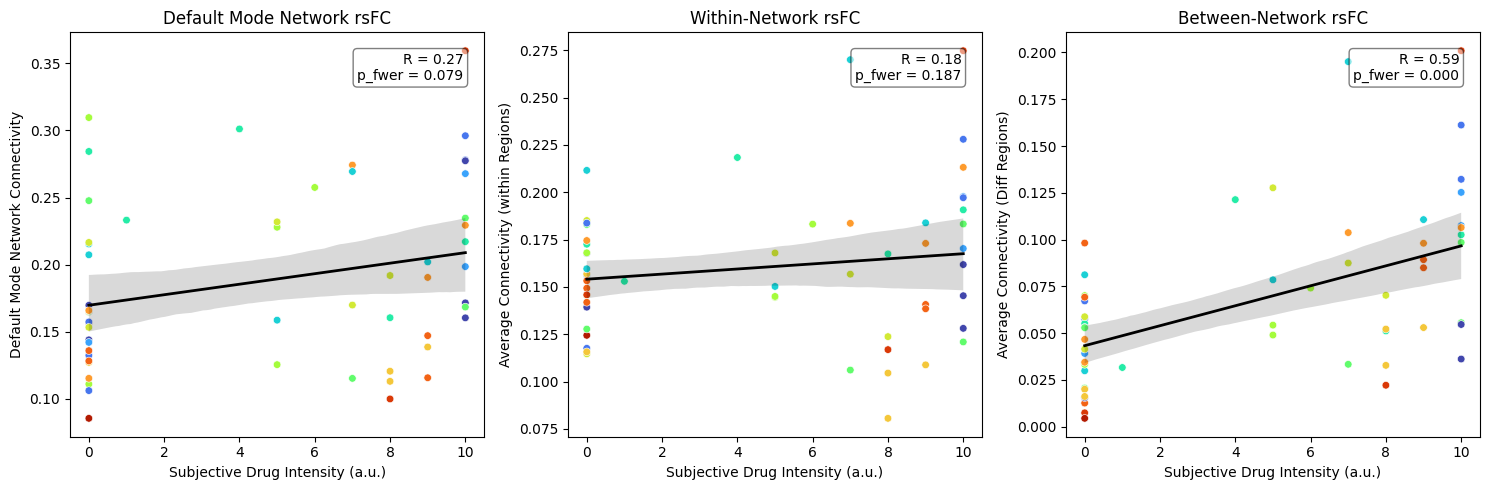

In [15]:
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a grid of subplots for 6 modes
# Generate results for the current mode
results_df = get_data(data_df, mode = 0, sample_rate=0.8, zFisher=True)
#results_df = get_data(data_df, mode = 1, sample_rate=2)
results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])

ax1, ax2, ax3 = axes   
# Left subplot: default_conn
p, R = lme_1(results_df, 'SDI')
sns.scatterplot(ax=ax1, x='SDI', y='default_conn', hue='subject', data=results_df, palette='turbo', s=30, legend=False)

sns.regplot(ax=ax1, x='SDI', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('Subjective Drug Intensity (a.u.)')
ax1.set_ylabel('Default Mode Network Connectivity')
ax1.set_title(f'Default Mode Network rsFC')

textstr = f"R = {R[0]:.2f}\np_fwer = {p[0]:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='SDI', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=30, legend=False)
sns.regplot(ax=ax2, x='SDI', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('Subjective Drug Intensity (a.u.)')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')

textstr = f"R = {R[1]:.2f}\np_fwer = {p[1]:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='SDI', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=30, legend=False)

sns.regplot(ax=ax3, x='SDI', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('Subjective Drug Intensity (a.u.)')
ax3.set_ylabel('Average Connectivity (Diff Regions)')
ax3.set_title(f'Between-Network rsFC')

textstr = f"R = {R[2]:.2f}\np_fwer = {p[2]:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [10]:
sub = results_df[results_df['SDI'] == 10]
np.max(sub['default_conn'])

0.24395132035608424

### MVMD Data

100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


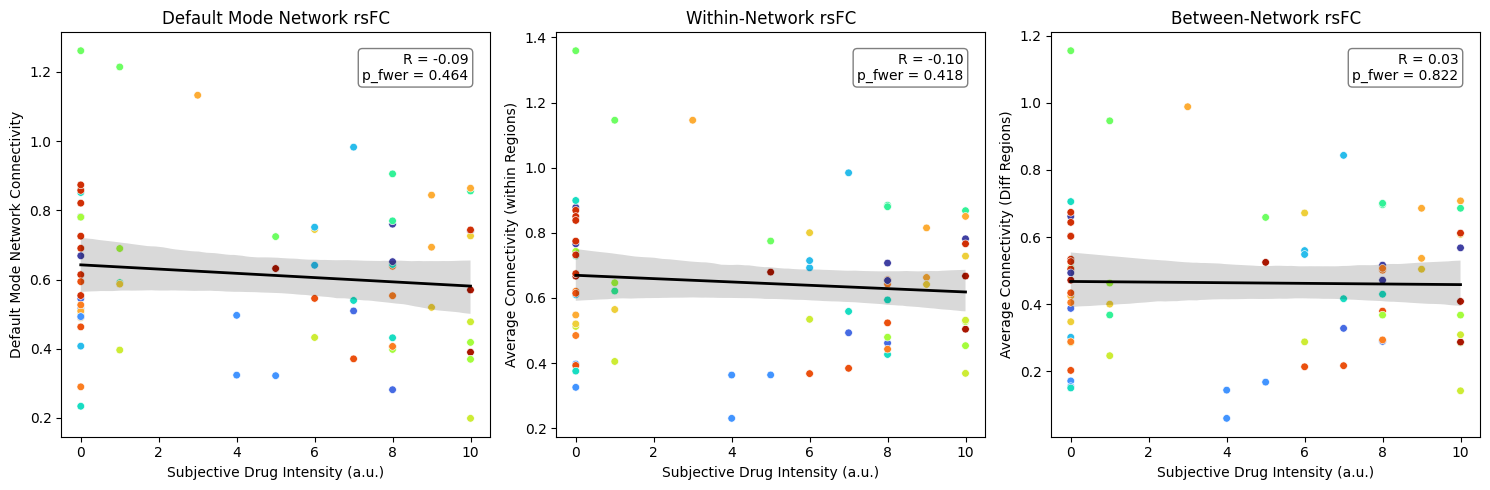

In [ ]:
data_df_modes = f.experiment_to_df('Run0605/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a grid of subplots for 6 modes
# Generate results for the current mode
results_df = get_data_modified(data_df_modes, modes = [1], sample_rate=2, zFisher=True)
#results_df = get_data(data_df, mode = 1, sample_rate=2)
results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])

ax1, ax2, ax3 = axes   
p, R = lme_1(results_df, 'SDI')

sns.scatterplot(ax=ax1, x='SDI', y='default_conn', hue='subject', data=results_df, palette='turbo', s=30, legend=False)

sns.regplot(ax=ax1, x='SDI', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('Subjective Drug Intensity (a.u.)')
ax1.set_ylabel('Default Mode Network Connectivity')
ax1.set_title(f'Default Mode Network rsFC')

textstr = f"R = {R[0]:.2f}\np_fwer = {p[0]:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='SDI', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=30, legend=False)
sns.regplot(ax=ax2, x='SDI', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('Subjective Drug Intensity (a.u.)')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')

textstr = f"R = {R[1]:.2f}\np_fwer = {p[1]:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='SDI', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=30, legend=False)

sns.regplot(ax=ax3, x='SDI', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('Subjective Drug Intensity (a.u.)')
ax3.set_ylabel('Average Connectivity (Diff Regions)')
ax3.set_title(f'Between-Network rsFC')

textstr = f"R = {R[2]:.2f}\np_fwer = {p[2]:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### MVMD Data

### TESTINT SOMETHING

In [298]:
data_df_modes = f.experiment_to_df('Run0605/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
results_df_modes = get_data_modified(data_df_modes, modes = [0,1,2,3,4,5], sample_rate=2, zFisher=True)


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


In [292]:
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
results_df = get_data(data_df, mode = 0, sample_rate=2, zFisher=True)

100%|██████████| 9/9 [00:02<00:00,  3.20it/s]


In [273]:
data_df.iloc[0].u.shape

(1, 232, 300)

In [293]:
results_df.iloc[1].average_connecvtivities[('Default', 'Default')]

0.14224825573043606

In [299]:
results_df_modes.iloc[1].average_connecvtivities[('Default', 'Default')]

0.14020118567399362

In [248]:
for i in range(0, len(results_df_modes)):
    print(np.average(results_df_modes.iloc[i].mat))

0.0406690239264875
0.04685347875524031
0.04407876097982546
0.030531381153083053
0.057985110708099606
0.0297121806211778
0.06408836340280998
0.02142862696085643
0.052407864241785854
0.09789463071528762
0.0368454145350408
0.02373892601132191
0.03650027636485342
0.036648548651525746
0.030943629989691482
0.03613643629195323
0.031553370099470957
0.06426380989874159
0.04262341148999918
0.0689293188543736
0.0611108577154796
0.14817980569292838
0.0775421366725659
0.05129937717235113
0.06507696965256977
0.028554802933497315
0.055814056130353444
0.049187718440640626
-0.004747797926594272
0.13637096971257004
0.04442878418652726
0.02030096804581472
0.048844183412919115
0.0651297169795729
0.04887676734348656
0.1522606283479711
0.07293487541179584
0.08597100145734672
0.11615006706199373
0.027720234366960333
0.03802517655686418
0.04319802502784321
0.04514063411228065
0.029128009512167784
0.04656300122469414
0.05045184190942661
0.04657370649439533
0.15331870300242623
0.05746910963523657
0.061572850688

In [246]:
np.average(results_df.iloc[1].mat)

0.04770781892559465

In [ ]:
data_df_modes.loc[(data_df_modes['subject'] == 'sub-53888' )& (data_df_modes['run'] == 0)].u[0].shape

(6, 232, 300)

In [253]:
results_df.iloc[0]

subject                                                            sub-53888
run                                                                        0
psi                                                                      0.0
SDI                                                                      0.0
average_connecvtivities    {('Vis', 'Vis'): 0.2797169279716207, ('Vis', '...
mat                        [[0.0, 0.5818178620316441, 0.10534029696116094...
Name: 0, dtype: object

In [254]:
results_df_modes.iloc[0]

subject                                                            sub-53888
run                                                                        0
psi                                                                      0.0
SDI                                                                      0.0
average_connecvtivities    {('Vis', 'Vis'): 0.26969992294107864, ('Vis', ...
mat                        [[0.0, 0.57051734608752, 0.10817270720265926, ...
Name: 0, dtype: object

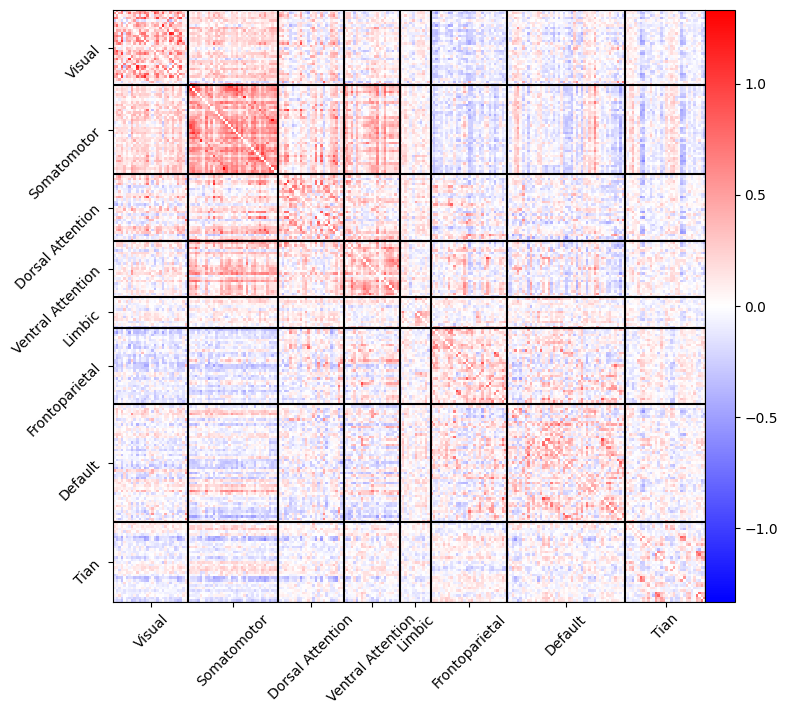

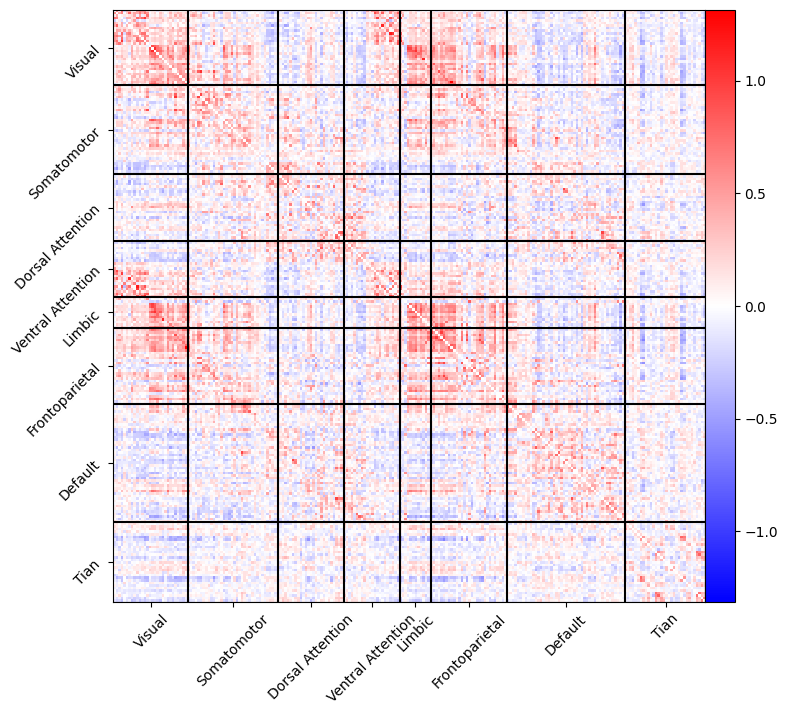

In [295]:
f.plot_label_matrix(results_df.iloc[0].mat, labels=modules_brain_ranges, limits = 'auto', lim_val = 1, fig_size=7)

f.plot_label_matrix(results_df_modes.iloc[0].mat, labels=modules_brain_ranges, limits = 'auto', lim_val = 1, fig_size=7)

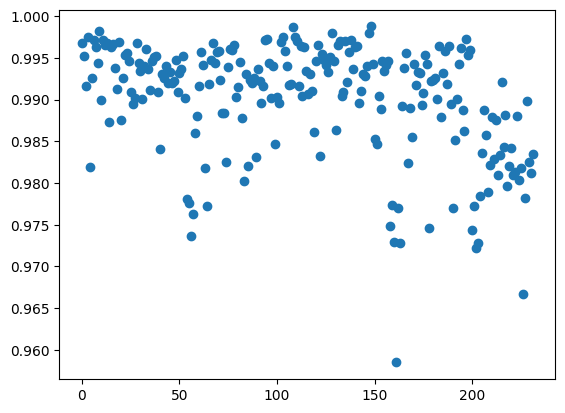

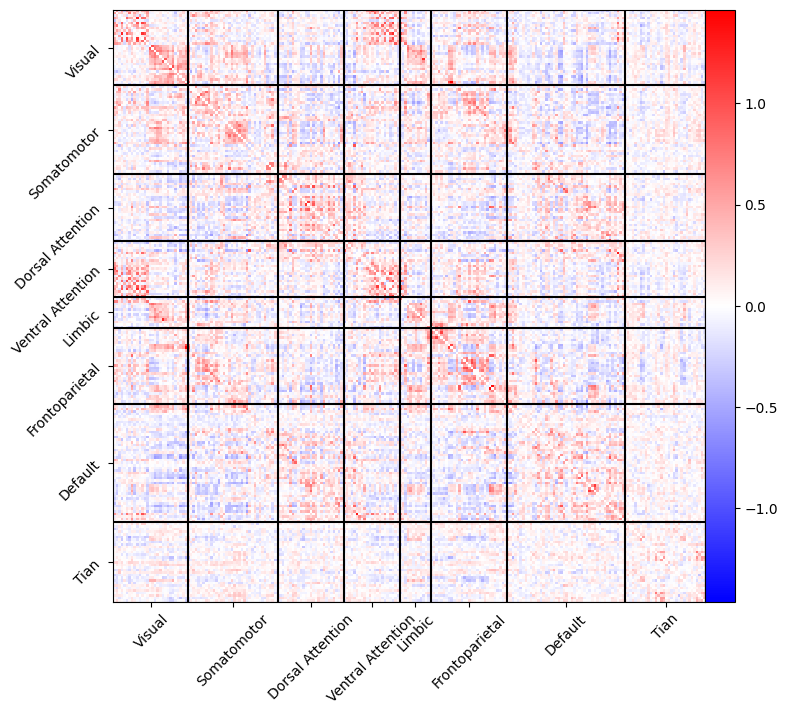

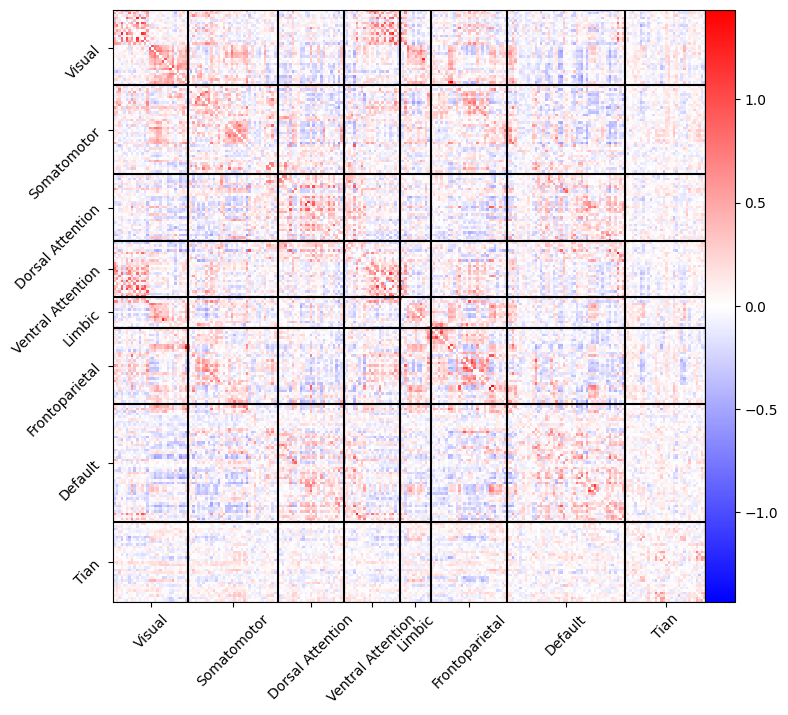

In [ ]:
s = l1[14]
us = data_df_modes[(data_df_modes['subject'] == s) & (data_df_modes['run'] == 0)].u.values[0]
sumofmodes = np.sum(us, axis=0)
original = data_df[(data_df['subject'] == s) & (data_df['run'] == 0)].u.values[0][0]


mat2= correlation_matrices_modified([sumofmodes], [0], zFisher=True)

f.plot_label_matrix(mat2[0], labels=modules_brain_ranges, limits = 'auto', lim_val = 1, fig_size=7)


100%|██████████| 9/9 [00:05<00:00,  1.64it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


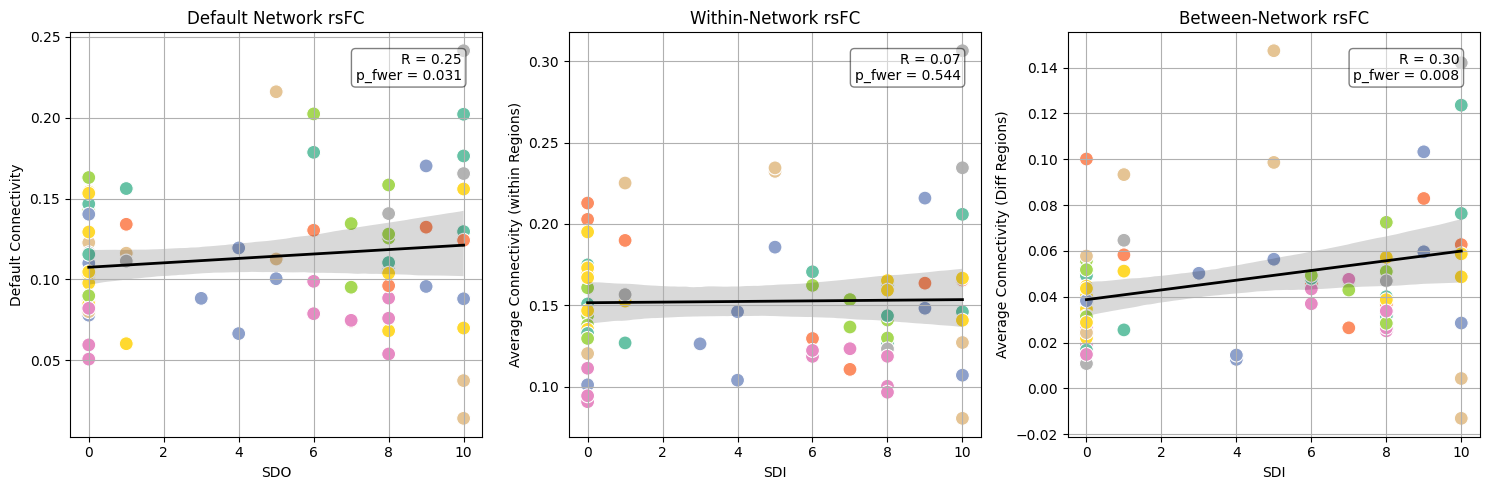

In [ ]:
data_df_modes = f.experiment_to_df('Run0605/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
#data_df_modes = data_df_modes[data_df_modes['subject'] == 'sub-53888']ta_df['SDI'] == 10))]
#data_df = data_df[data_df['subject'] == 'sub-55992']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a grid of subplots for 6 modes
# Generate results for the current mode
results_df = get_data_modified(data_df_modes, modes = [0,1,2,3,4,5], sample_rate=2, zFisher=True)
#results_df = get_data(data_df, mode = 1, sample_rate=2)
results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['average_connectivity_within_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_same_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])

ax1, ax2, ax3 = axes   
# Left subplot: default_conn
sns.scatterplot(ax=ax1, x='SDI', y='default_conn', hue='subject', data=results_df, palette='turbo', s=100, legend=False)
sns.regplot(ax=ax1, x='SDI', y='default_conn', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax1.set_xlabel('SDO')
ax1.set_ylabel('Default Connectivity')
ax1.set_title(f'Default Network rsFC')
ax1.grid(True)

p, R = lme_1(results_df, 'SDI', 'default_conn')
textstr = f"R = {R:.2f}\np_fwer = {p:.3f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.95, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Middle subplot: average_connectivity_within_regions
sns.scatterplot(ax=ax2, x='SDI', y='average_connectivity_within_regions', hue='subject', data=results_df, palette='turbo', s=100, legend=False)
sns.regplot(ax=ax2, x='SDI', y='average_connectivity_within_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax2.set_xlabel('SDI')
ax2.set_ylabel('Average Connectivity (within Regions)')
ax2.set_title(f'Within-Network rsFC')
ax2.grid(True)

p, R = lme_1(results_df, 'SDI', 'average_connectivity_within_regions')
textstr = f"R = {R:.2f}\np_fwer = {p:.3f}"
ax2.text(0.95, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Right subplot: average_connectivity_diff_regions
sns.scatterplot(ax=ax3, x='SDI', y='average_connectivity_diff_regions', hue='subject', data=results_df, palette='turbo', s=100, legend=False)
sns.regplot(ax=ax3, x='SDI', y='average_connectivity_diff_regions', data=results_df, scatter=False, color='black', line_kws={"linewidth": 2})
ax3.set_xlabel('SDI')
ax3.set_ylabel('Average Connectivity (Diff Regions)')
ax3.set_title(f'Between-Network rsFC')
ax3.grid(True)

p, R = lme_1(results_df, 'SDI', 'average_connectivity_diff_regions')
textstr = f"R = {R:.2f}\np_fwer = {p:.3f}"
ax3.text(0.95, 0.95, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=props)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## LME stuff

In [3]:
data_df_modes = f.experiment_to_df('Run0905/Results_0mean')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
results_df = get_data_modified(data_df_modes, modes = [1], sample_rate=0.8)

results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
results_df['default_conn'] = results_df['average_connecvtivities'].apply(lambda x: x[('Default', 'Default')])

100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


### Detailed results

In [33]:
from itertools import combinations
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests

def lme(df_sub, area_pair, predictor):
    #df_sub : dataframe with subjects, runs, and fc's
    df_sub = df_sub.copy()
    df_sub['fc_z'] = df_sub['average_connecvtivities'].apply(lambda x: x[area_pair])
    m = smf.mixedlm(f"fc_z ~ {predictor}", df_sub,
                    groups=df_sub["subject"])
    return m.fit(reml=True)


def get_lme_result_df(results_df, predictor):
    net_labels = list(modules_brain_ranges.keys())
    results = []
    
    pairs = list(combinations(net_labels, 2)) + [(n, n) for n in net_labels]
    for n1, n2 in pairs:
        res = lme(results_df, (n1, n2), predictor)

        # Extract estimates and confidence intervals
        intercept = res.params['Intercept']
        ci_intercept = res.conf_int().loc['Intercept'].tolist()

        beta = res.params[predictor]
        ci_beta = res.conf_int().loc[predictor].tolist()

        p_unc = res.pvalues[predictor]

        results.append({
            'Network': f'{n1}-{n2}' if n1 != n2 else n1,
            'Intercept': intercept,
            '95% CI of intercept': ci_intercept,
            'β-estimate': beta,
            '95% CI of β': ci_beta,
            'p_unc': p_unc,
        })

    # Convert to DataFrame
    results_df_long = pd.DataFrame(results)

    # Multiple comparison correction
    reject, p_fwer, _, _ = multipletests(results_df_long['p_unc'], alpha=0.05, method='holm')
    results_df_long['p_FWER'] = p_fwer
    return results_df_long

In [16]:
%%capture
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
results_df = get_data(data_df, mode = 0, sample_rate=2)

outdir = 'Results/denoised_psi_2.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='psi')
pickle.dump(denoised_df_res_psi, open(outdir, 'wb'))
denoised_df_res_psi.to_csv(outdir)

In [17]:
%%capture
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
results_df = get_data(data_df, mode = 0, sample_rate=0.8)

outdir = 'Results/denoised_psi_08.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='psi')
denoised_df_res_psi.to_csv(outdir)

In [18]:
%%capture
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
results_df = get_data(data_df, mode = 0, sample_rate=2)

outdir = 'Results/denoised_SDI_2.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='SDI')
denoised_df_res_psi.to_csv(outdir)

In [19]:
%%capture
data_df = pickle.load(open('DATA/denoised.pkl', 'rb'))
data_df = load_and_append_psilocin_data(data_df)
results_df = get_data(data_df, mode = 0, sample_rate=0.8)

outdir = 'Results/denoised_SDI_08.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='SDI')
denoised_df_res_psi.to_csv(outdir)

Now with MVMD

In [53]:
data_df = f.experiment_to_df('Run0905/Results_0mean', sub2000 = 'K_6', sub800='K_10')

data_df = load_and_append_psilocin_data(data_df)

In [50]:
results_df = get_data_modified(data_df, modes = [1], sample_rate=2)

outdir = 'Results/mvmd_psi_2.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='psi')
denoised_df_res_psi.to_csv(outdir)

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]


In [51]:
results_df = get_data_modified(data_df, modes = [1], sample_rate=0.8)

outdir = 'Results/mvmd_psi_08.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='psi')
denoised_df_res_psi.to_csv(outdir)

100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


In [54]:
results_df = get_data_modified(data_df, modes = [1], sample_rate=2)

outdir = 'Results/mvmd_SDI_2.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='SDI')
denoised_df_res_psi.to_csv(outdir)

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


In [52]:
results_df = get_data_modified(data_df, modes = [1], sample_rate=0.8)

outdir = 'Results/mvmd_SDI_08.csv'
denoised_df_res_psi = get_lme_result_df(results_df, predictor='SDI')
denoised_df_res_psi.to_csv(outdir)

100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


### Running for different modes

In [2]:
def lme(df_sub, area_pair, predictor):
    #df_sub : dataframe with subjects, runs, and fc's
    df_sub = df_sub.copy()
    df_sub['fc_z'] = df_sub['average_connecvtivities'].apply(lambda x: x[area_pair])
    m = smf.mixedlm(f"fc_z ~ {predictor}", df_sub,
                    groups=df_sub["subject"])
    return m.fit(reml=True)

data_df_modes = f.experiment_to_df('Run0905/Results_0mean')
data_df_modes = load_and_append_psilocin_data(data_df_modes)
results_df = get_data_modified(data_df_modes, modes = [1], sample_rate=0.8)

results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
data_df = load_and_append_psilocin_data(data_df)

NameError: name 'f' is not defined

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings(
    "ignore",
    message="The MLE may be on the boundary of the parameter space.",
    category=ConvergenceWarning,
    module="statsmodels.regression.mixed_linear_model")

def lme(df_sub, area_pair, predictor):
    #df_sub : dataframe with subjects, runs, and fc's
    df_sub = df_sub.copy()
    df_sub['fc_z'] = df_sub['average_connecvtivities'].apply(lambda x: x[area_pair])
    m = smf.mixedlm(f"fc_z ~ {predictor}", df_sub,
                    groups=df_sub["subject"])
    return m.fit(reml=True)


def perform_lme_exp(results_df, output_dir=None, predictor='psi'):
    net_labels = list(modules_brain_ranges.keys())
    beta = []
    p_unc = []
    pairs = []
    for n1, n2 in list(combinations(net_labels, 2)) + [(n, n) for n in net_labels]:
        res = lme(results_df, (n1,n2), predictor)
        beta.append(res.params[predictor])
        p_unc.append(res.pvalues[predictor])
        pairs.append((n1, n2))
    
    reject, p_fwer, _, _ = multipletests(p_unc, alpha=0.05, method="holm")


    k = len(net_labels)
    beta_mat  = np.full((k, k), np.nan)
    pun_mat   = beta_mat.copy()
    pfwer_mat = beta_mat.copy()

    idx = {n:i for i,n in enumerate(net_labels)}
    for (n1, n2), b, pu, pf in zip(pairs, beta, p_unc, p_fwer):
        i, j = idx[n1], idx[n2]
        beta_mat[i, j]  = beta_mat[j, i]  = b
        pun_mat[i, j]   = pun_mat[j, i]   = pu
        pfwer_mat[i, j] = pfwer_mat[j, i] = pf

    mask = np.triu(np.ones_like(beta_mat, dtype=bool), 1)   # hide upper tri
    fig, ax = plt.subplots(figsize=(6,5))

    sns.heatmap(beta_mat, mask=mask, vmin=-0.02, vmax=0.02,
                cmap='coolwarm', square=True, cbar_kws={"label": "β"},
                xticklabels=net_labels, yticklabels=net_labels, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=60, ha="right", rotation_mode="anchor")

    for i in range(k):
        for j in range(i+1):
            if np.isnan(beta_mat[i,j]): continue
            star = ""
            if pun_mat[i,j]  < 0.05: star = "*"
            if pfwer_mat[i,j] < 0.05: star = "**"
            if star:
                ax.text(j+0.5, i+0.5, star, ha="center", va="center",
                    color="k", fontsize=10, fontweight="bold")

#ax.set_title("PPL vs Functional Connectivity 2000ms")
    plt.tight_layout()
    if output_dir:
        plt.savefig(output_dir, dpi=300)
        plt.close()
    else:
        plt.show()



In [6]:
data_df = f.experiment_to_df('Run1005/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df = load_and_append_psilocin_data(data_df)

In [7]:
from os.path import join

In [13]:
data_df = f.experiment_to_df('Run1005/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df = load_and_append_psilocin_data(data_df)
base = 'Figures/LME_Models_Different_Modes/Single'
modeslist = [[1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]]
srs = [0.8]
for sr in srs:
    for modeslist in tqdm(modeslist):
        results_df = get_data_modified(data_df, modes=modeslist, sample_rate=sr)
        subdir = join(base, f'SR_{sr}')
        if not os.path.exists(subdir):
            os.makedirs(subdir)
        results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
        perform_lme_exp(results_df, output_dir=f'{subdir}/Modes_{str(modeslist)}.png')

100%|██████████| 9/9 [00:03<00:00,  2.61it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/

In [9]:
mvmd_single = f.experiment_to_df('Run1005/Results_0mean', sub2000 = 'K_6', sub800='K_10')
mvmd_combined_between_runs = f.experiment_to_df('Run0605/Results_0mean', sub2000 = 'K_6', sub800='K_10')
mvmd_combined_across_runs = f.experiment_to_df('Run0905/Results_0mean', sub2000 = 'K_6', sub800='K_10')
mvmd_denoised = f.experiment_to_df('Run0605/Results_denoised', sub2000 = 'K_6', sub800='K_10')

In [6]:
mvmd_single = load_and_append_psilocin_data(mvmd_single)
base = 'Figures/LME_Models_Different_Modes/Single'
modeslist = [[1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]]
srs = [2]
for sr in srs:
    for modeslist in tqdm(modeslist):
        results_df = get_data_modified(mvmd_single, modes=modeslist, sample_rate=sr)
        subdir = join(base, f'SR_{sr}')
        if not os.path.exists(subdir):
            os.makedirs(subdir)
        results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
        perform_lme_exp(results_df, output_dir=f'{subdir}/Modes_{str(modeslist)}.png')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
100%|██████████| 7/7 [00:26<00:00,  3.74s/it]


In [10]:
mvmd_combined_between_runs = load_and_append_psilocin_data(mvmd_combined_between_runs)
base = 'Figures/LME_Models_Different_Modes/Combined_Between_Runs'
modeslist = [[1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]]
srs = [0.8]
for sr in srs:
    for modeslist in tqdm(modeslist):
        results_df = get_data_modified(mvmd_combined_between_runs, modes=modeslist, sample_rate=sr)
        subdir = join(base, f'SR_{sr}')
        if not os.path.exists(subdir):
            os.makedirs(subdir)
        results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
        perform_lme_exp(results_df, output_dir=f'{subdir}/Modes_{str(modeslist)}.png')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:03<00:00,  2.57it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/

In [11]:
mvmd_combined_across_runs = load_and_append_psilocin_data(mvmd_combined_across_runs)
base = 'Figures/LME_Models_Different_Modes/Combined_Across_Runs'
modeslist = [[1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]]
srs = [0.8]
for sr in srs:
    for modeslist in tqdm(modeslist):
        results_df = get_data_modified(mvmd_combined_across_runs, modes=modeslist, sample_rate=sr)
        subdir = join(base, f'SR_{sr}')
        if not os.path.exists(subdir):
            os.makedirs(subdir)
        results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
        perform_lme_exp(results_df, output_dir=f'{subdir}/Modes_{str(modeslist)}.png')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:03<00:00,  2.59it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/mod

In [12]:
mvmd_denoised = load_and_append_psilocin_data(mvmd_denoised)
base = 'Figures/LME_Models_Different_Modes/Denoised'
modeslist = [[0], [1], [2], [0,1], [0,2], [1,2], [0,1,2]]
srs = [0.8]
for sr in srs:
    for modeslist in tqdm(modeslist):
        results_df = get_data_modified(mvmd_denoised, modes=modeslist, sample_rate=sr)
        subdir = join(base, f'SR_{sr}')
        if not os.path.exists(subdir):
            os.makedirs(subdir)
        results_df['average_connectivity_diff_regions'] = results_df['average_connecvtivities'].apply(calculate_average_connectivity_diff_regions)
        perform_lme_exp(results_df, output_dir=f'{subdir}/Modes_{str(modeslist)}.png')

100%|██████████| 9/9 [00:03<00:00,  2.66it/s]
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/base/

### Experiments for denoised

In [47]:
sr=2
data_df = f.experiment_to_df('Run0905/Results_0mean', sub2000 = 'K_6', sub800='K_10')
data_df = load_and_append_psilocin_data(data_df)

results_df = get_data_modified(data_df, modes = [1], sample_rate=sr)

100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


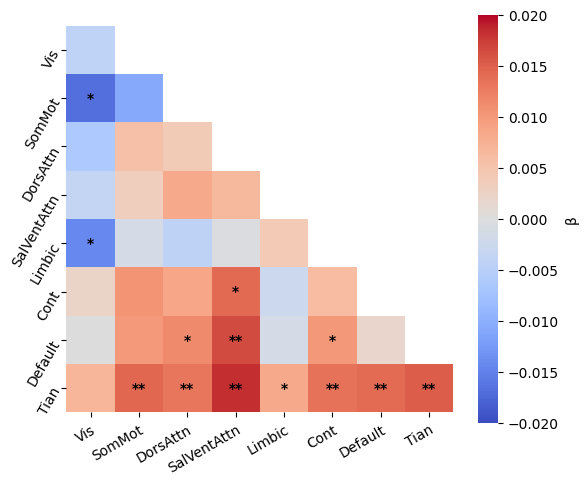

In [48]:
perform_lme_exp(results_df=results_df, predictor='SDI', output_dir=None)

In [25]:
net_labels = list(modules_brain_ranges.keys())
beta = []
p_unc = []
pairs = []
predictor = 'psi'
for n1, n2 in list(combinations(net_labels, 2)) + [(n, n) for n in net_labels]:
    res = lme(results_df, (n1,n2), predictor)
    beta.append(res.params[predictor])
    p_unc.append(res.pvalues[predictor])
    pairs.append((n1, n2))
pairs

NameError: name 'lme' is not defined

In [56]:
reject, p_fwer, _, _ = multipletests(p_unc, alpha=0.05, method="holm")

In [ ]:
%%capture

net_labels = list(modules_brain_ranges.keys())
beta = []
p_unc = []
pairs = []
predictor = 'psi'
for n1, n2 in list(combinations(net_labels, 2)) + [(n, n) for n in net_labels]:
    res = lme(results_df, (n1,n2), predictor)
    beta.append(res.params[predictor])
    p_unc.append(res.pvalues[predictor])
    pairs.append((n1, n2))
    
reject, p_fwer, _, _ = multipletests(p_unc, alpha=0.05, method="holm")

import matplotlib.pyplot as plt
import seaborn as sns

k = len(net_labels)
beta_mat  = np.full((k, k), np.nan)
pun_mat   = beta_mat.copy()
pfwer_mat = beta_mat.copy()

idx = {n:i for i,n in enumerate(net_labels)}
for (n1, n2), b, pu, pf in zip(pairs, beta, p_unc, p_fwer):
    i, j = idx[n1], idx[n2]
    beta_mat[i, j]  = beta_mat[j, i]  = b
    pun_mat[i, j]   = pun_mat[j, i]   = pu
    pfwer_mat[i, j] = pfwer_mat[j, i] = pf

######################################################################
mask = np.triu(np.ones_like(beta_mat, dtype=bool), 1)   # hide upper tri
fig, ax = plt.subplots(figsize=(6,5))

sns.heatmap(beta_mat, mask=mask, vmin=-0.02, vmax=0.02,
            cmap = 'coolwarm', square=True, cbar_kws={"label": "β"},
            xticklabels=net_labels, yticklabels=net_labels, ax=ax)

for i in range(k):
    for j in range(i+1):
        if np.isnan(beta_mat[i,j]): continue
        star = ""
        if pun_mat[i,j]  < 0.05: star = "*"
        if pfwer_mat[i,j] < 0.05: star = "**"
        if star:
            ax.text(j+0.5, i+0.5, star, ha="center", va="center",
                    color="k", fontsize=10, fontweight="bold")

#ax.set_title("PPL vs Functional Connectivity 2000ms")
plt.tight_layout()
#plt.savefig('Figures/LME/PPL_vs_FC_800ms_MVMD.png', dpi=300)
plt.show()

In [30]:
mvmd_combined_across_runs = f.experiment_to_df('Run0905/Results_0mean', sub2000 = 'K_6', sub800='K_10')
mvmd_combined_across_runs = load_and_append_psilocin_data(mvmd_combined_across_runs)

results_df = get_data_modified(mvmd_combined_across_runs, modes = [1], sample_rate=2)

100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


/users/konstantinosvosinas/.local/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


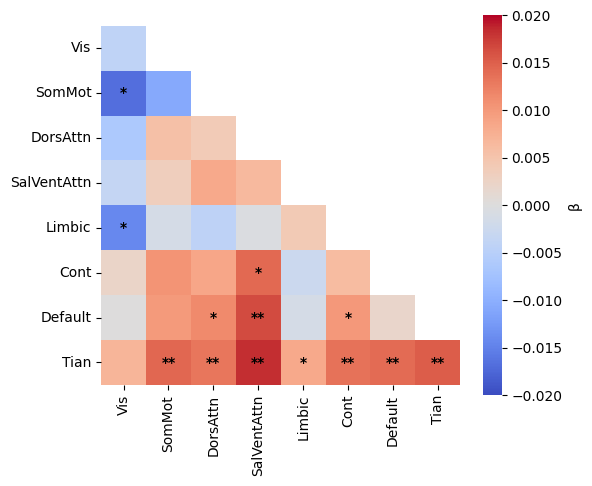

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

net_labels = list(modules_brain_ranges.keys())
beta = []
p_unc = []
pairs = []
predictor = 'SDI'
for n1, n2 in list(combinations(net_labels, 2)) + [(n, n) for n in net_labels]:
    res = lme(results_df, (n1,n2), predictor)
    beta.append(res.params[predictor])
    p_unc.append(res.pvalues[predictor])
    pairs.append((n1, n2))
    
reject, p_fwer, _, _ = multipletests(p_unc, alpha=0.05, method="holm")


k = len(net_labels)
beta_mat  = np.full((k, k), np.nan)
pun_mat   = beta_mat.copy()
pfwer_mat = beta_mat.copy()

idx = {n:i for i,n in enumerate(net_labels)}
for (n1, n2), b, pu, pf in zip(pairs, beta, p_unc, p_fwer):
    i, j = idx[n1], idx[n2]
    beta_mat[i, j]  = beta_mat[j, i]  = b
    pun_mat[i, j]   = pun_mat[j, i]   = pu
    pfwer_mat[i, j] = pfwer_mat[j, i] = pf

######################################################################
mask = np.triu(np.ones_like(beta_mat, dtype=bool), 1)   # hide upper tri
fig, ax = plt.subplots(figsize=(6,5))

sns.heatmap(beta_mat, mask=mask, vmin=-0.02, vmax=0.02,
            cmap = 'coolwarm', square=True, cbar_kws={"label": "β"},
            xticklabels=net_labels, yticklabels=net_labels, ax=ax)

for i in range(k):
    for j in range(i+1):
        if np.isnan(beta_mat[i,j]): continue
        star = ""
        if pun_mat[i,j]  < 0.05: star = "*"
        if pfwer_mat[i,j] < 0.05: star = "**"
        if star:
            ax.text(j+0.5, i+0.5, star, ha="center", va="center",
                    color="k", fontsize=10, fontweight="bold")

#ax.set_title("SDI vs Functional Connectivity 2000ms")
plt.tight_layout()
#plt.savefig('Figures/LME/SDI_vs_FC_800ms_MVMD.png', dpi=300)
plt.show()